In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'USD'
share_name = 'FR.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2013-12-31,59,-31,28,-81,45,9,27,110,0,...,855,21,0,34,77,26,284,26,-38,116.9
1,2014-03-31,65,-35,30,6,39,12,29,102,0,...,868,21,0,33,83,23,286,19,-26,117.4
2,2014-06-30,67,-43,24,8,65,8,24,118,0,...,891,16,0,36,72,49,298,27,-27,117.4
3,2014-09-30,41,-32,9,-11,33,7,33,88,0,...,875,21,0,38,76,42,291,5,-26,117.4
4,2014-12-31,73,-45,28,-65,40,5,18,75,0,...,771,26,0,38,78,30,251,42,-26,117.4


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2022-12-31,2023-02-11,263.1,148,-161,-13,-17,151,9,65,...,0,2110,41,0,14,167,210,699,-15,-55
37,2023-03-31,2023-04-21,277.2,157,-158,-1,-101,105,7,71,...,0,1984,34,0,17,141,212,653,-5,-49
38,2023-06-30,2023-07-21,277.2,147,-137,9,-18,160,5,58,...,0,2014,36,0,17,126,214,638,20,-37
39,2023-09-30,2023-10-21,277.2,133,-120,13,-27,138,9,61,...,0,1952,22,0,17,100,217,613,20,-34
40,2023-12-31,2024-02-11,277.2,137,-119,18,10,126,10,64,...,0,1976,32,0,18,120,219,618,25,-26


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,263.1,148,-161,-13,-17,151,9,65,...,2110,41,0,14,167,210,699,-15,-55,1.357405
37,2023-03-31,2023-04-21,277.2,157,-158,-1,-101,105,7,71,...,1984,34,0,17,141,212,653,-5,-49,1.352063
38,2023-06-30,2023-07-21,277.2,147,-137,9,-18,160,5,58,...,2014,36,0,17,126,214,638,20,-37,1.343352
39,2023-09-30,2023-10-21,277.2,133,-120,13,-27,138,9,61,...,1952,22,0,17,100,217,613,20,-34,1.341033
40,2023-12-31,2024-02-11,277.2,137,-119,18,10,126,10,64,...,1976,32,0,18,120,219,618,25,-26,1.361617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,263.1,200.895953,-218.542219,-17.646266,-23.075886,204.968168,12.216646,88.231331,...,2864.124729,55.653608,0.0,19.003671,226.686649,285.055068,948.826154,-20.361076,-74.657280,1.357405
37,2023-03-31,2023-04-21,277.2,212.273837,-213.625900,-1.352063,-136.558328,141.966579,9.464439,95.996449,...,2682.492309,45.970130,0.0,22.985065,190.640834,286.637283,882.896914,-6.760313,-66.251070,1.352063
38,2023-06-30,2023-07-21,277.2,197.472703,-184.039186,12.090166,-24.180331,214.936276,6.716759,77.914400,...,2705.510371,48.360662,0.0,22.836979,169.262317,287.477269,857.058400,26.867034,-49.704014,1.343352
39,2023-09-30,2023-10-21,277.2,178.357379,-160.923951,17.433428,-36.207889,185.062543,12.069296,81.803008,...,2617.696266,29.502724,0.0,22.797560,134.103292,291.004144,822.053182,26.820658,-45.595119,1.341033
40,2023-12-31,2024-02-11,277.2,186.541582,-162.032469,24.509113,13.616174,171.563791,13.616174,87.143513,...,2690.555961,43.571756,0.0,24.509113,163.394087,298.194208,841.479546,34.040435,-35.402052,1.361617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-02-17,13.329360,2013-12-31,61.91402,-2.908489,5.125764,116.9,268.643882,2.298066,47.222557,...,0.667836,0.332164,26.222222,5.904762,5.244444,4.592593,0.474576,-1.372881,-0.378947,-0.567426
1,2014-02-24,12.099566,2013-12-31,61.91402,-2.908489,5.125764,116.9,268.643882,2.298066,47.222557,...,0.667836,0.332164,26.222222,5.904762,5.244444,4.592593,0.474576,-1.372881,-0.378947,-0.567426
2,2014-03-03,12.248332,2013-12-31,61.91402,-2.908489,5.125764,116.9,268.643882,2.298066,47.222557,...,0.667836,0.332164,26.222222,5.904762,5.244444,4.592593,0.474576,-1.372881,-0.378947,-0.567426
3,2014-03-10,12.674792,2013-12-31,61.91402,-2.908489,5.125764,116.9,268.643882,2.298066,47.222557,...,0.667836,0.332164,26.222222,5.904762,5.244444,4.592593,0.474576,-1.372881,-0.378947,-0.567426
4,2014-03-17,12.238415,2013-12-31,61.91402,-2.908489,5.125764,116.9,268.643882,2.298066,47.222557,...,0.667836,0.332164,26.222222,5.904762,5.244444,4.592593,0.474576,-1.372881,-0.378947,-0.567426


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-02-17,13.329360,2013-12-31,61.91402,-2.908489,5.125764,116.9,268.643882,2.298066,47.222557,...,4.592593,0.474576,-1.372881,-0.378947,-0.567426,-4.582915,2.600463,6.291799,7.304511,5.800252
1,2014-02-24,12.099566,2013-12-31,61.91402,-2.908489,5.125764,116.9,268.643882,2.298066,47.222557,...,4.592593,0.474576,-1.372881,-0.378947,-0.567426,-4.160086,2.360539,5.711304,6.724016,5.265109
2,2014-03-03,12.248332,2013-12-31,61.91402,-2.908489,5.125764,116.9,268.643882,2.298066,47.222557,...,4.592593,0.474576,-1.372881,-0.378947,-0.567426,-4.211235,2.389562,5.781526,6.794238,5.329844
3,2014-03-10,12.674792,2013-12-31,61.91402,-2.908489,5.125764,116.9,268.643882,2.298066,47.222557,...,4.592593,0.474576,-1.372881,-0.378947,-0.567426,-4.357861,2.472762,5.982826,6.995538,5.515418
4,2014-03-17,12.238415,2013-12-31,61.91402,-2.908489,5.125764,116.9,268.643882,2.298066,47.222557,...,4.592593,0.474576,-1.372881,-0.378947,-0.567426,-4.207825,2.387628,5.776845,6.789556,5.325529


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

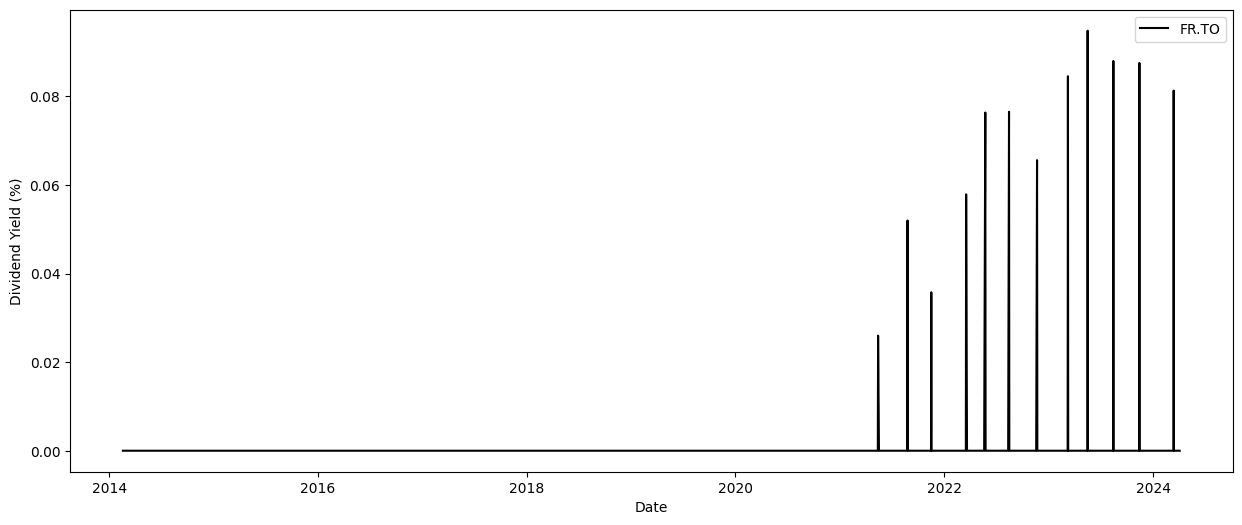

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.11354
share_price      1.00000
Name: share_price, dtype: float64


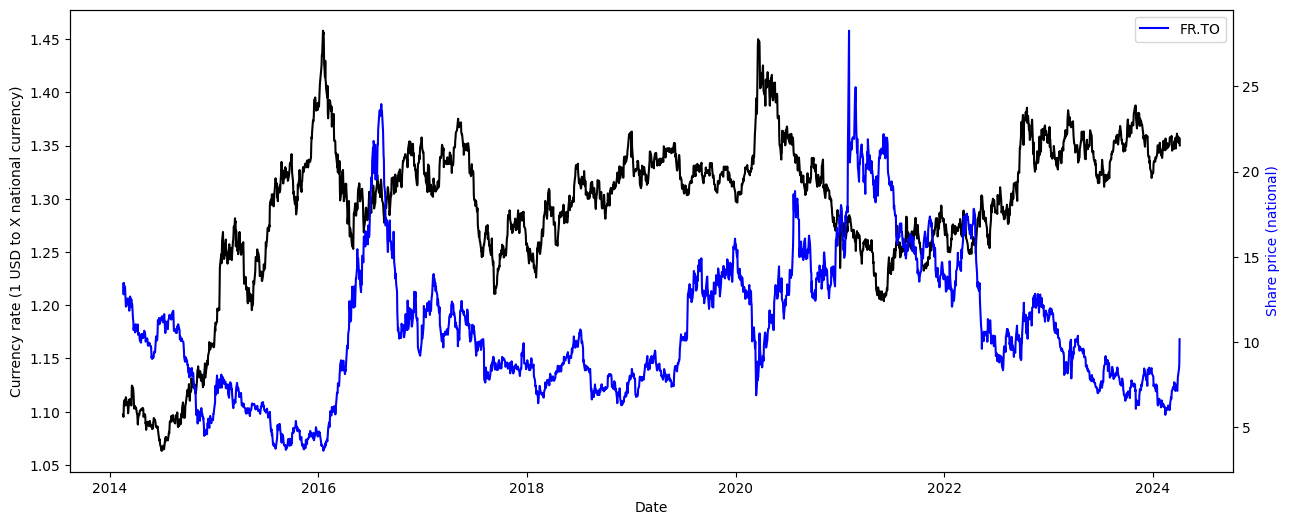

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

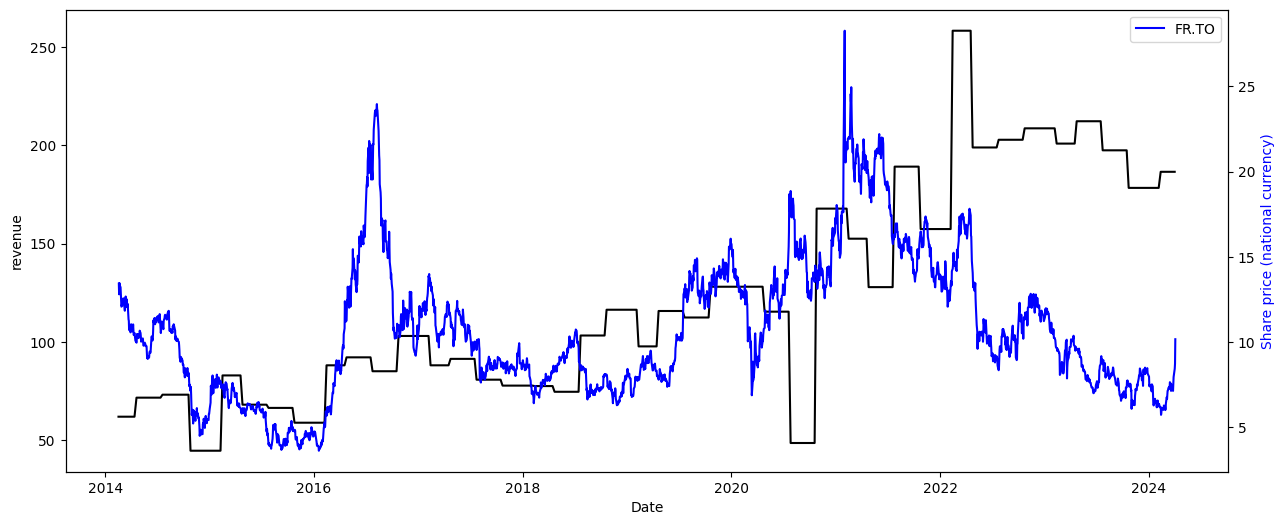

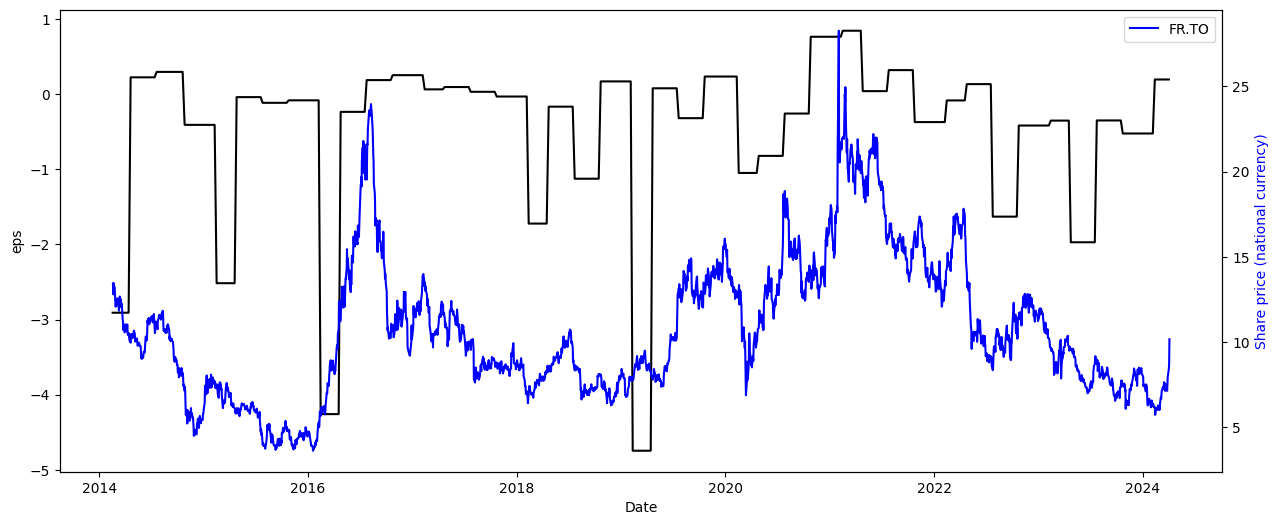

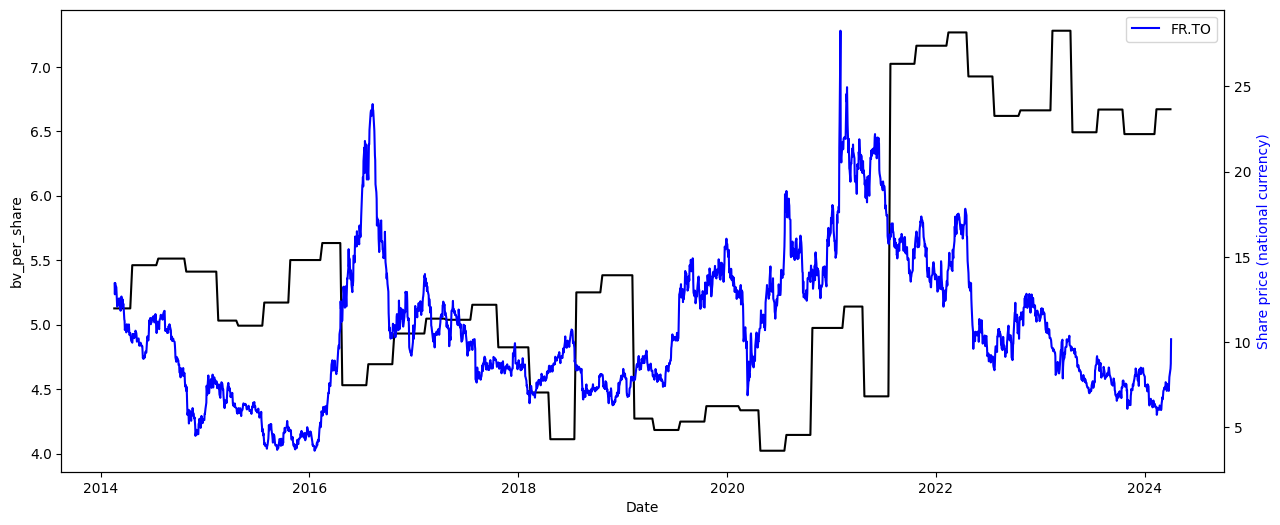

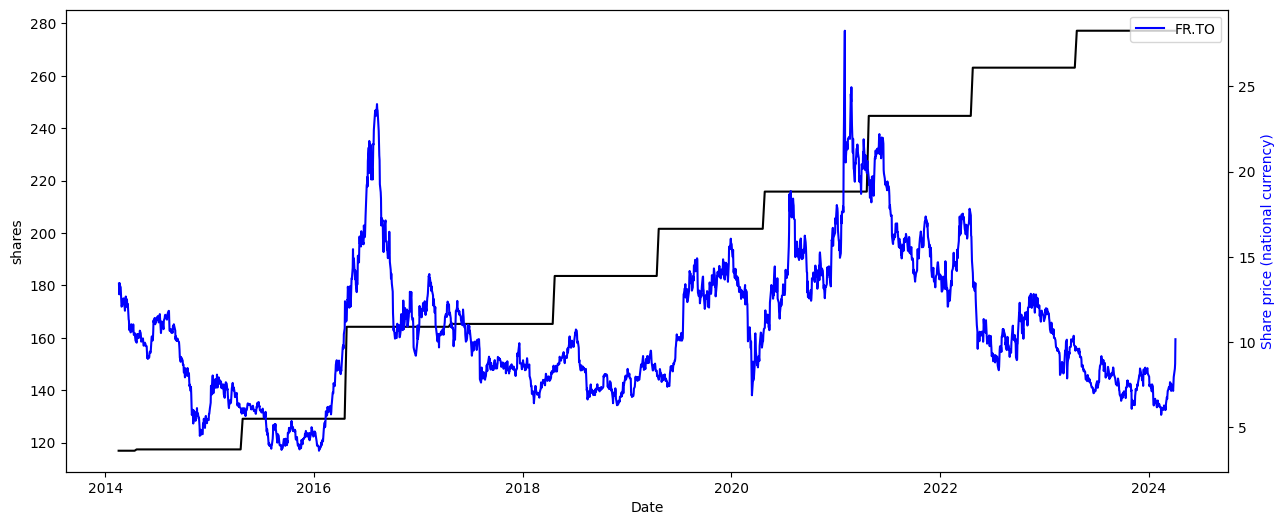

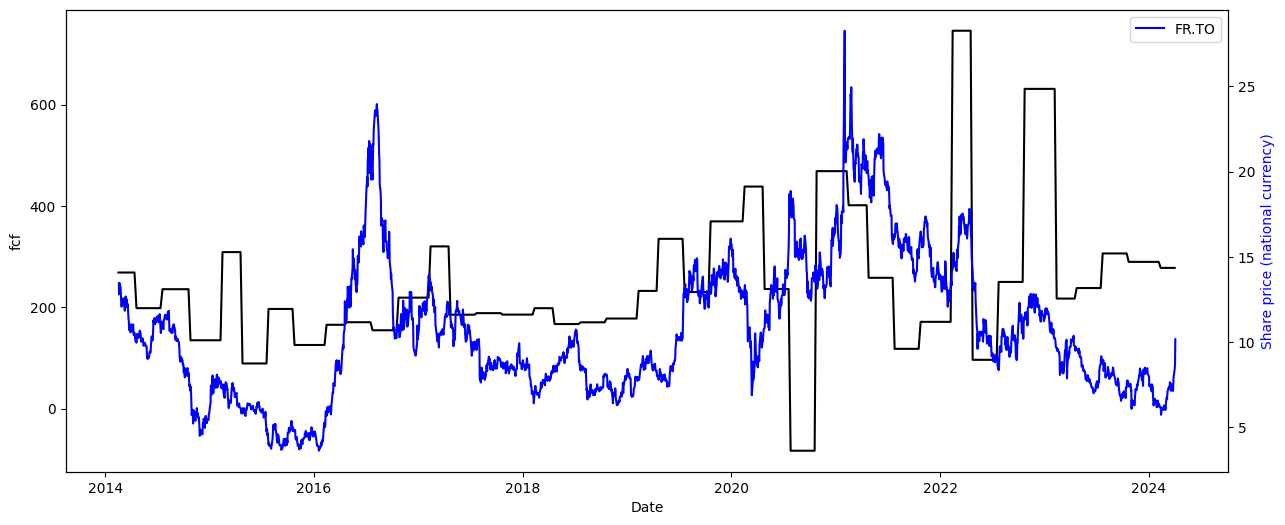

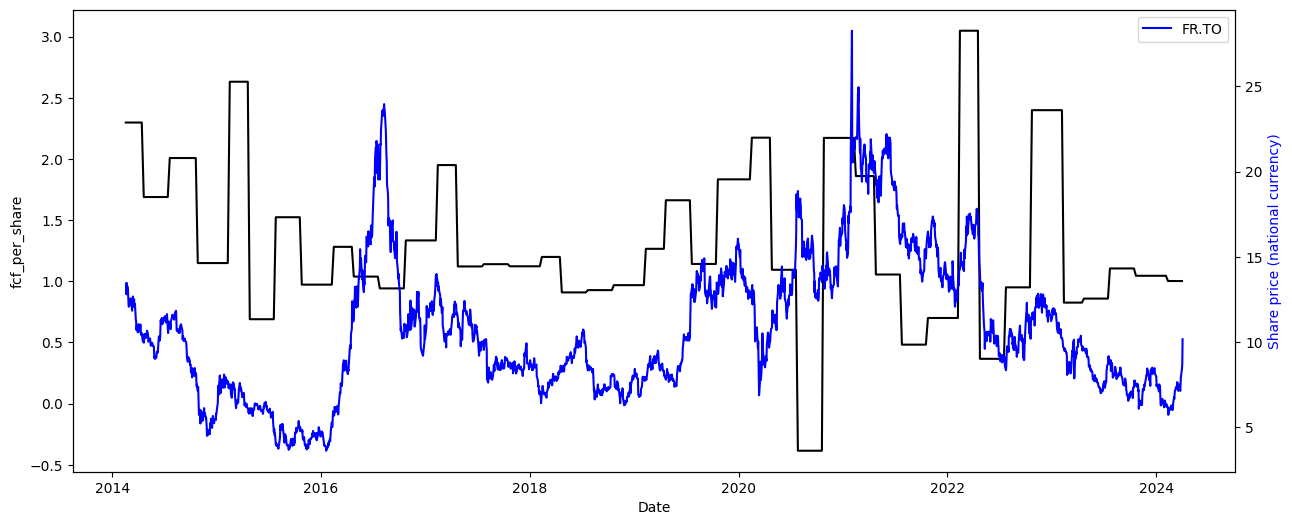

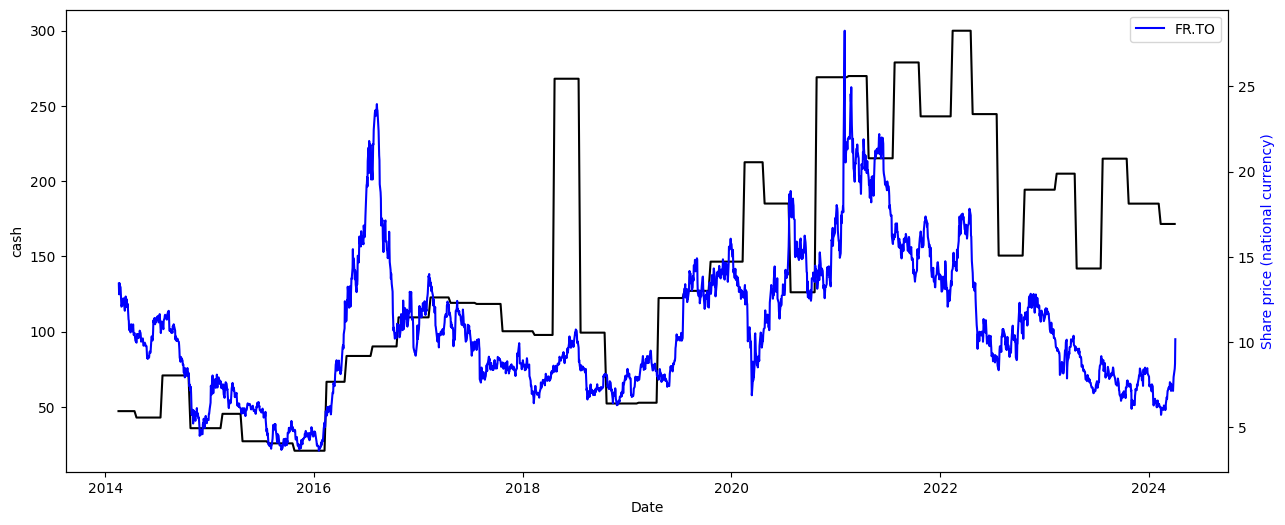

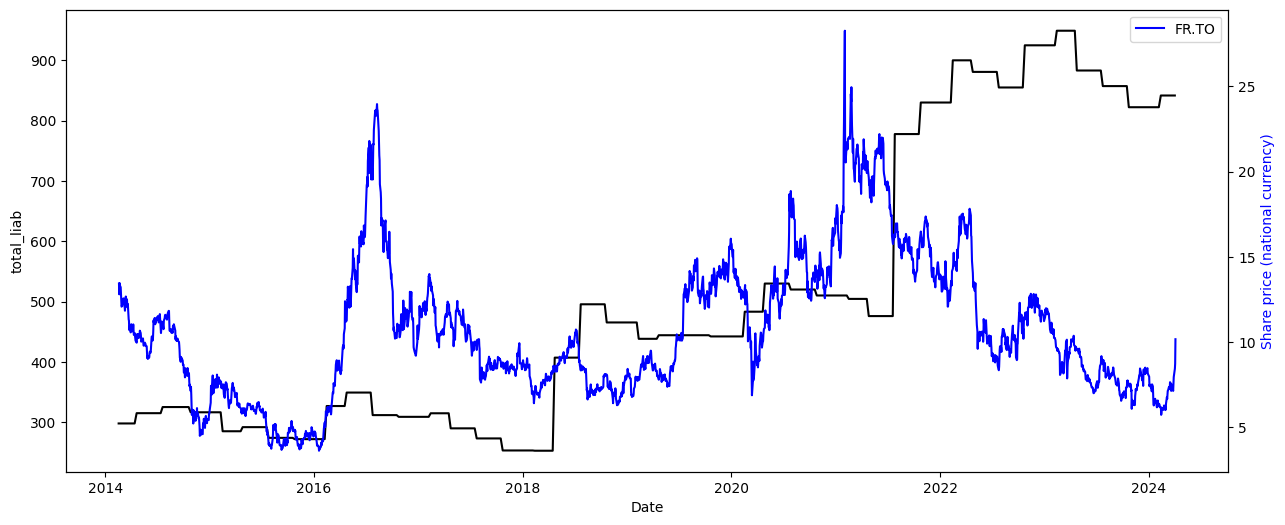

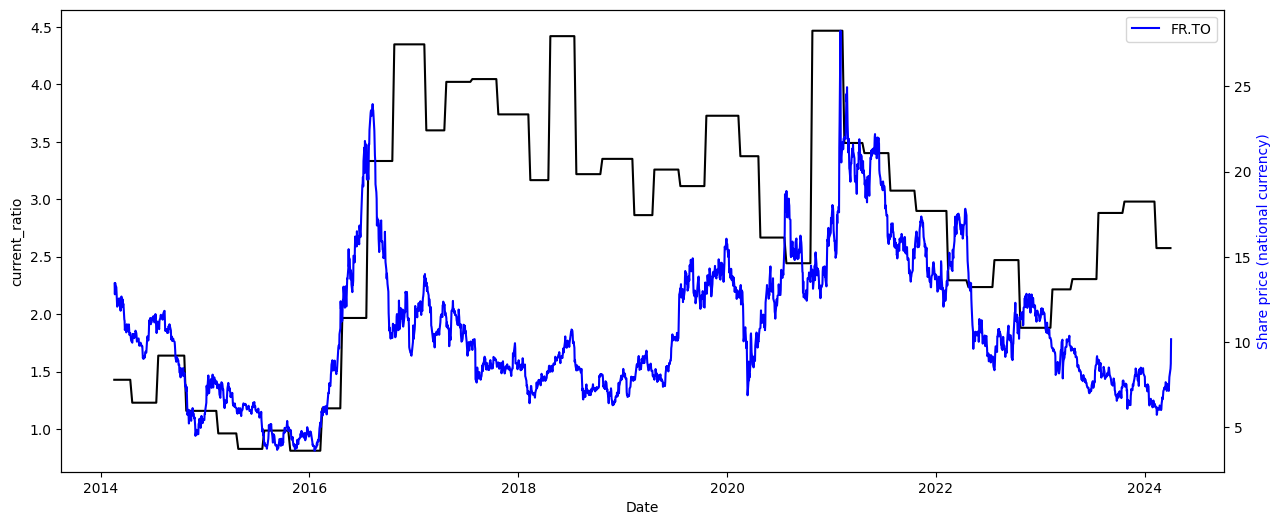

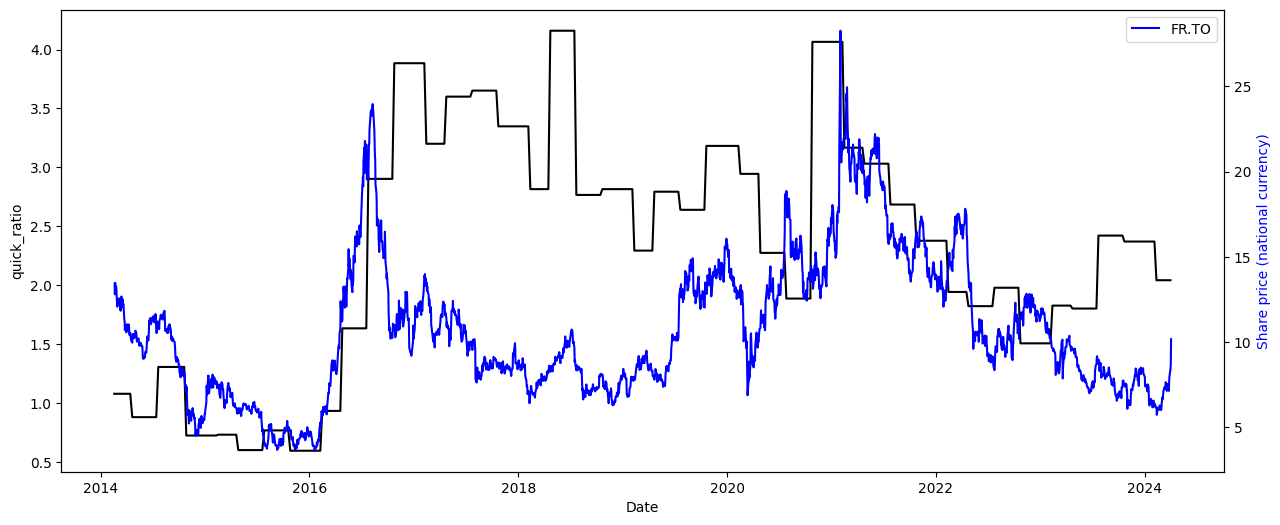

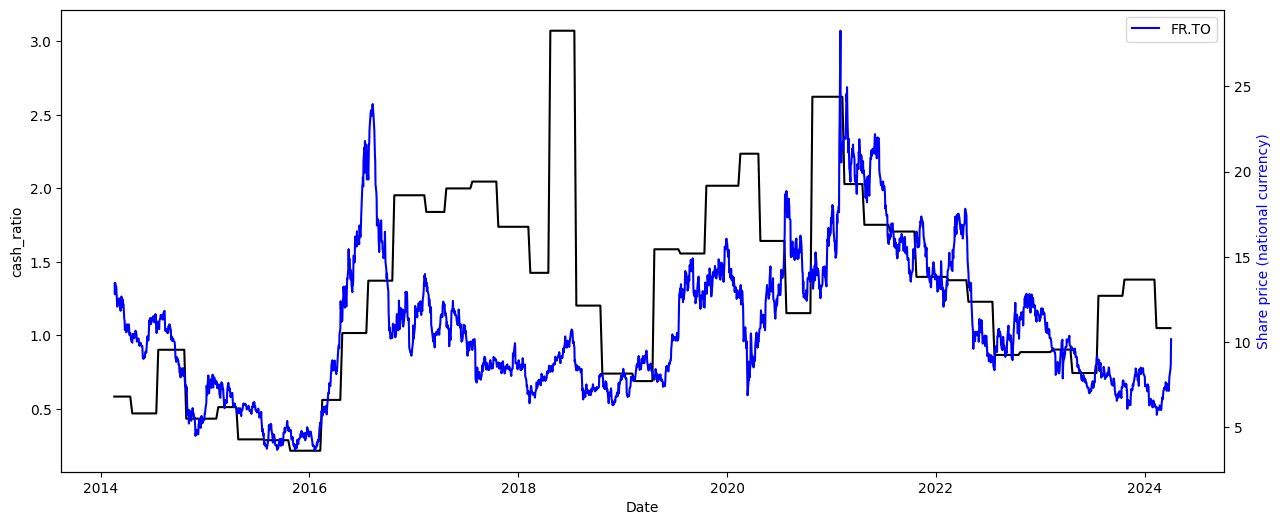

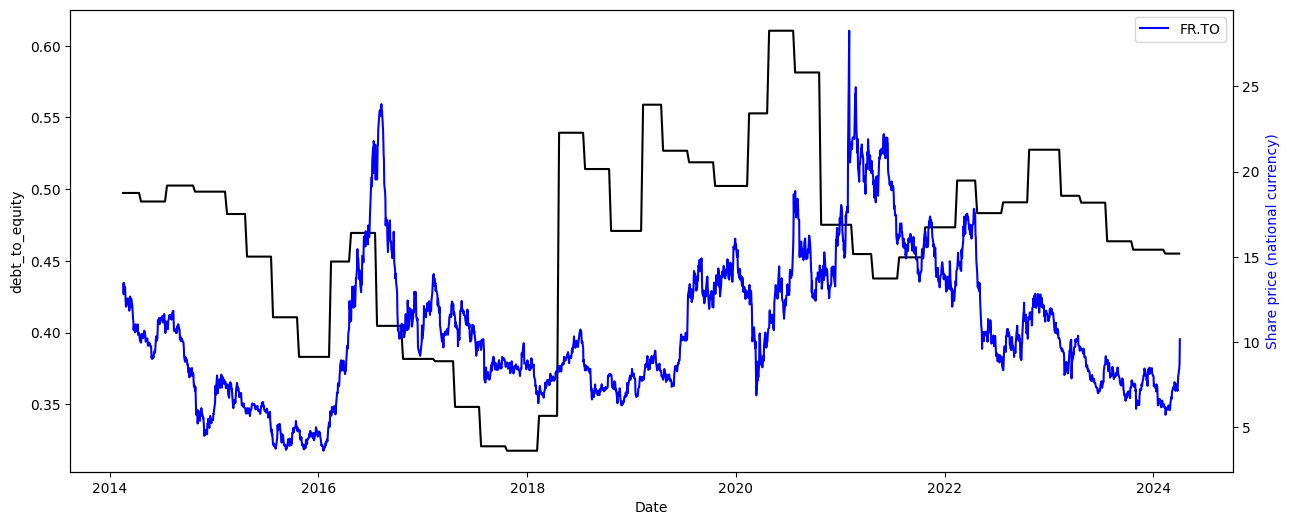

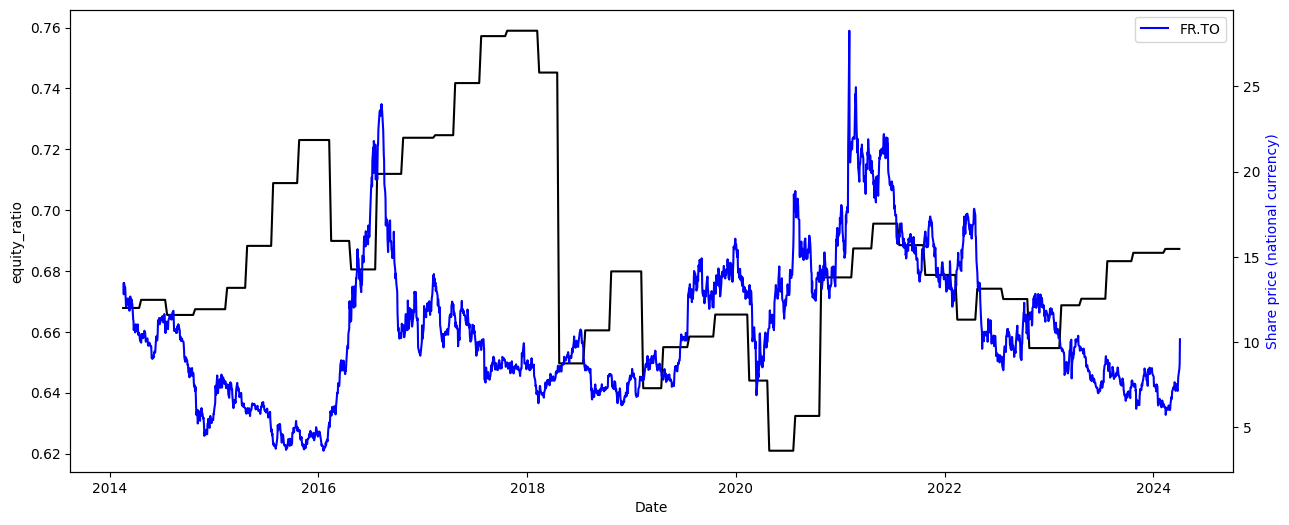

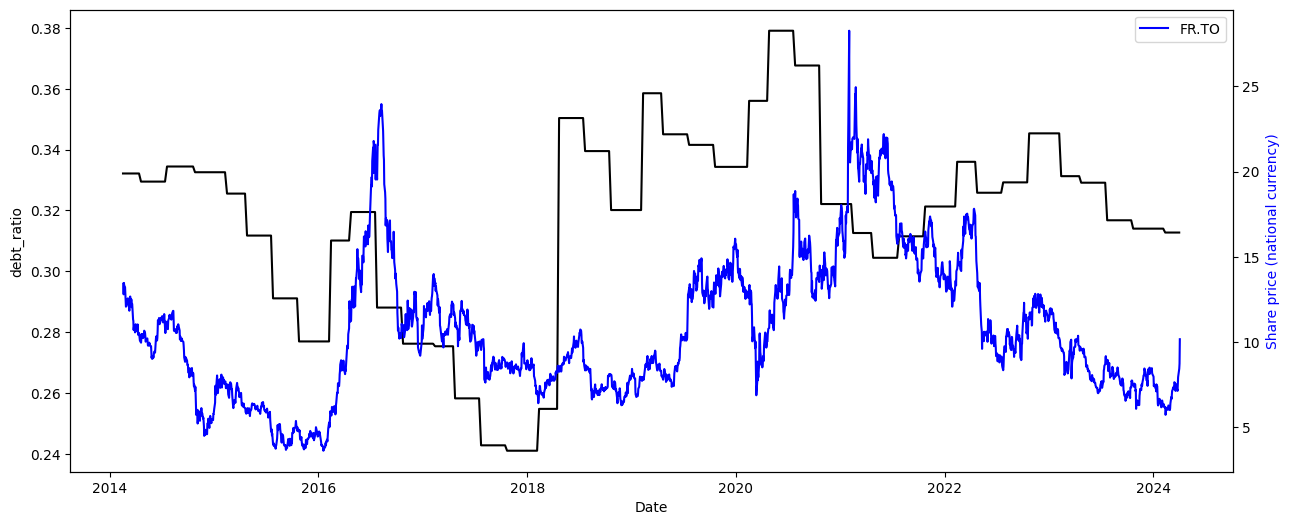

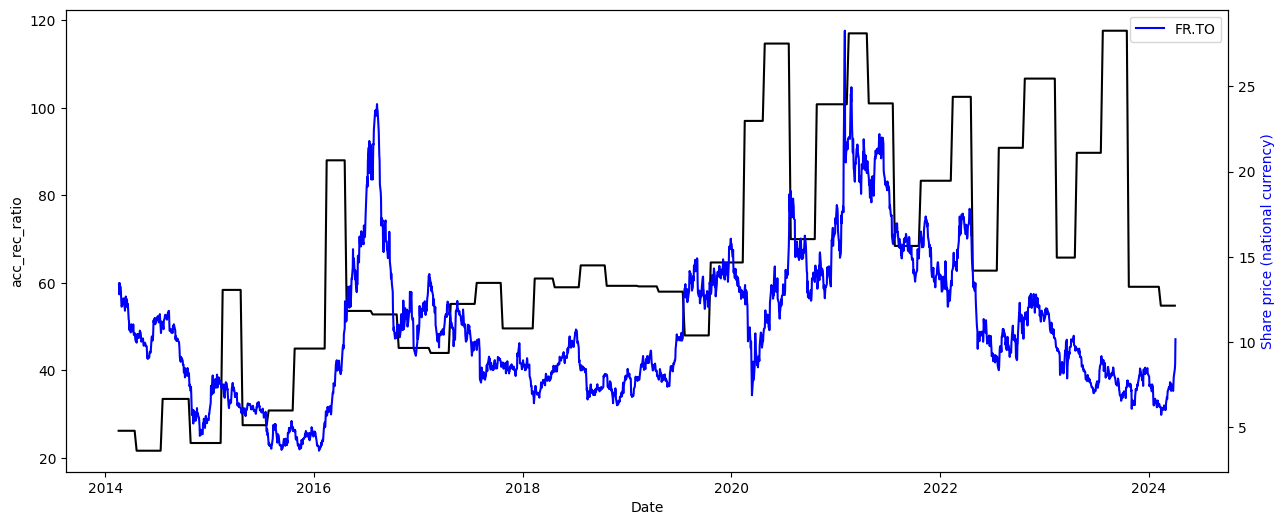

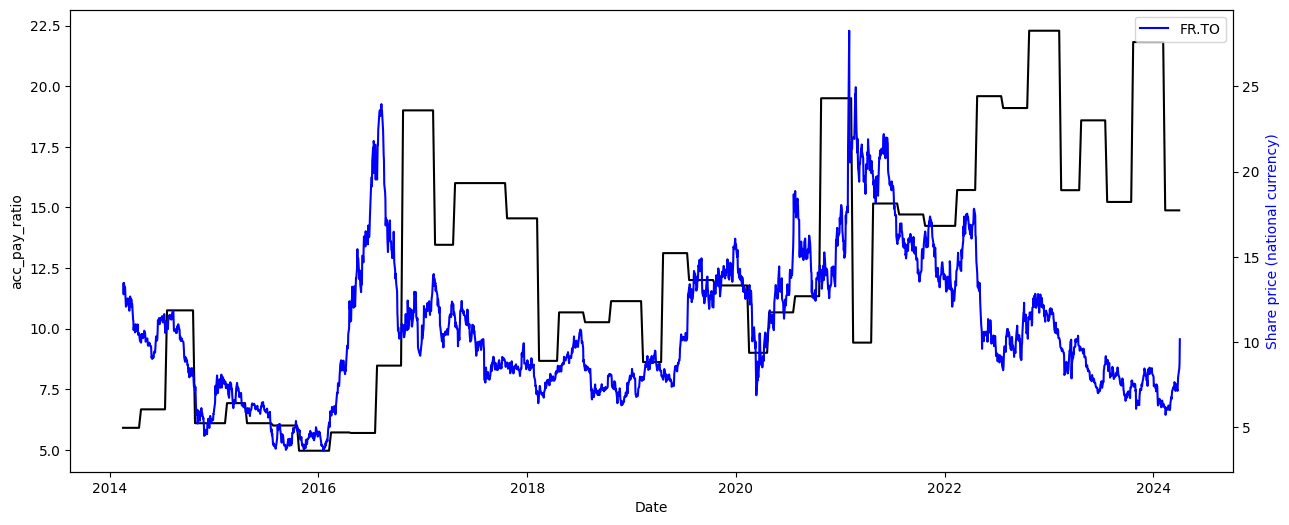

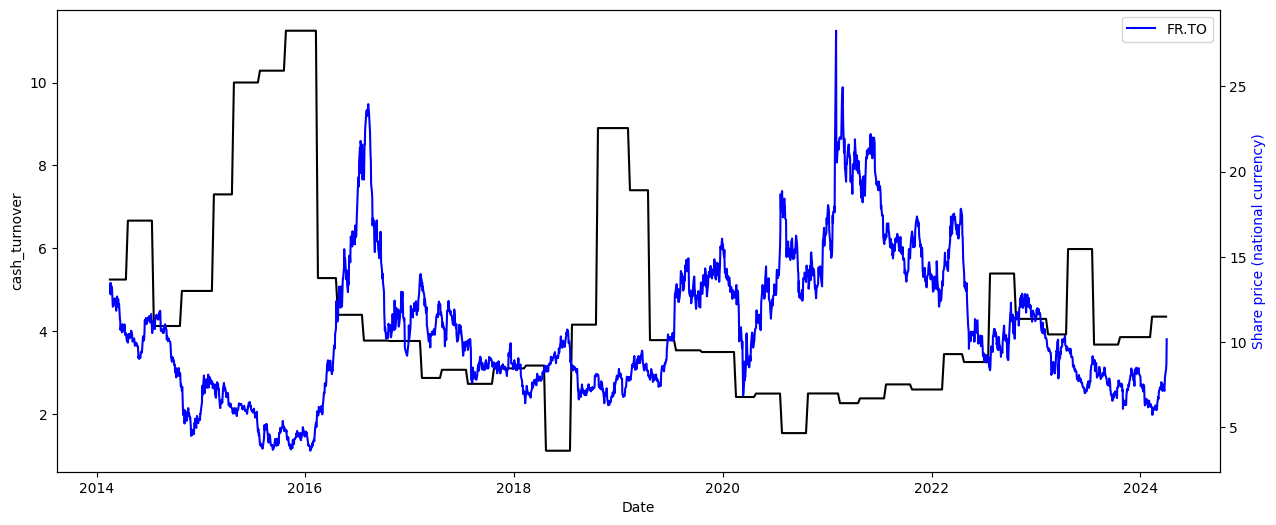

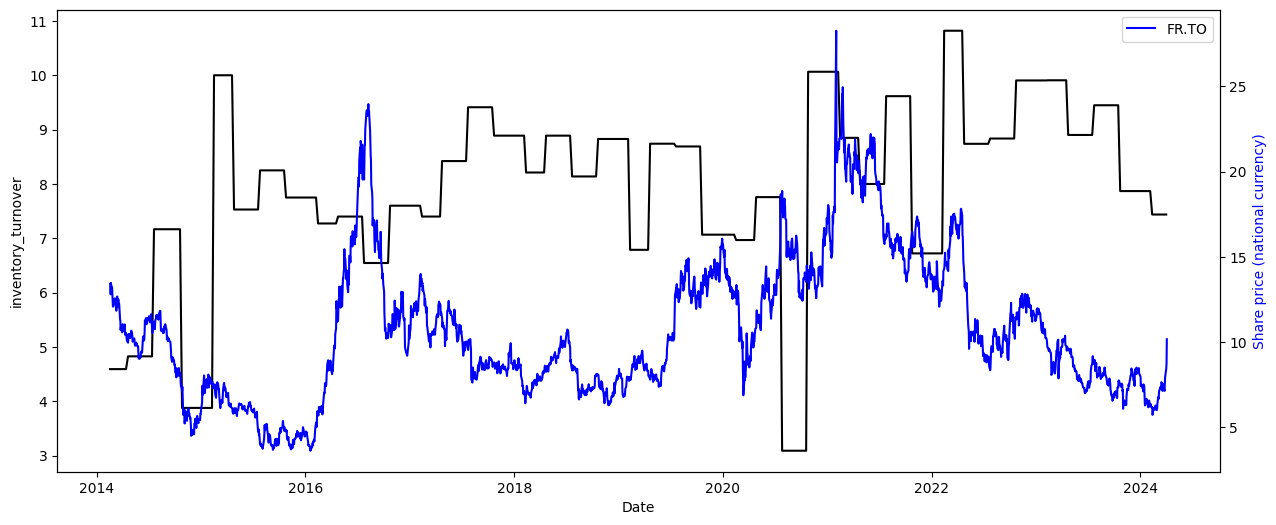

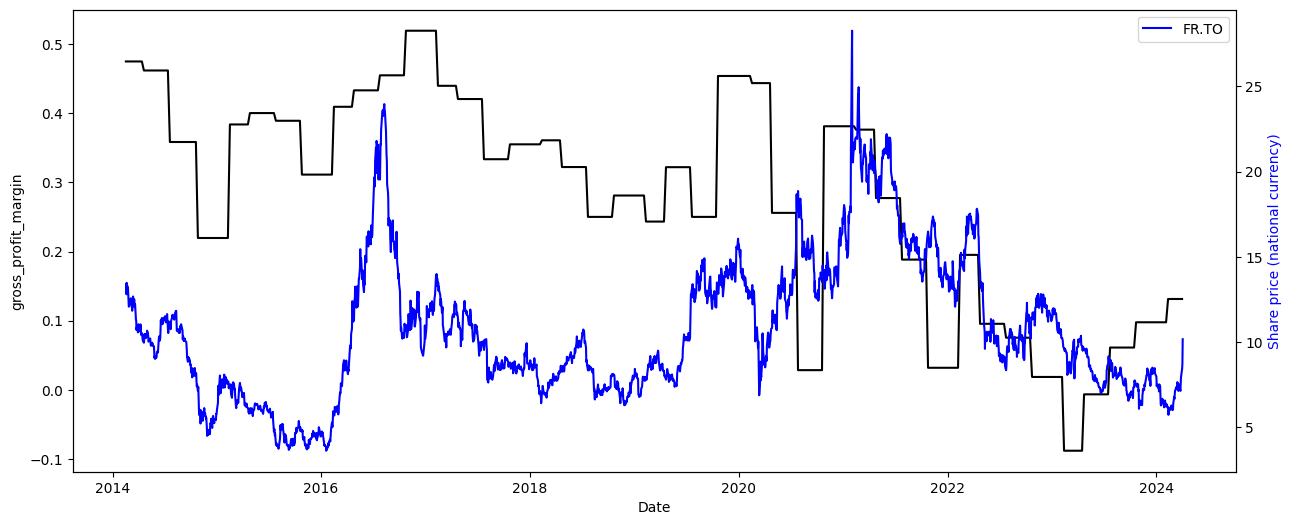

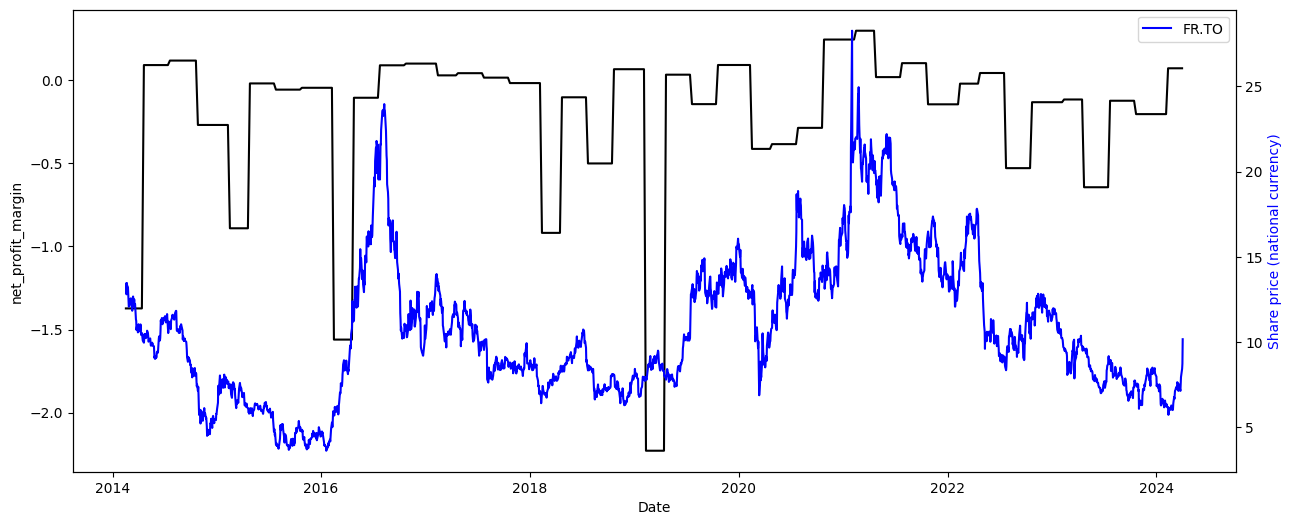

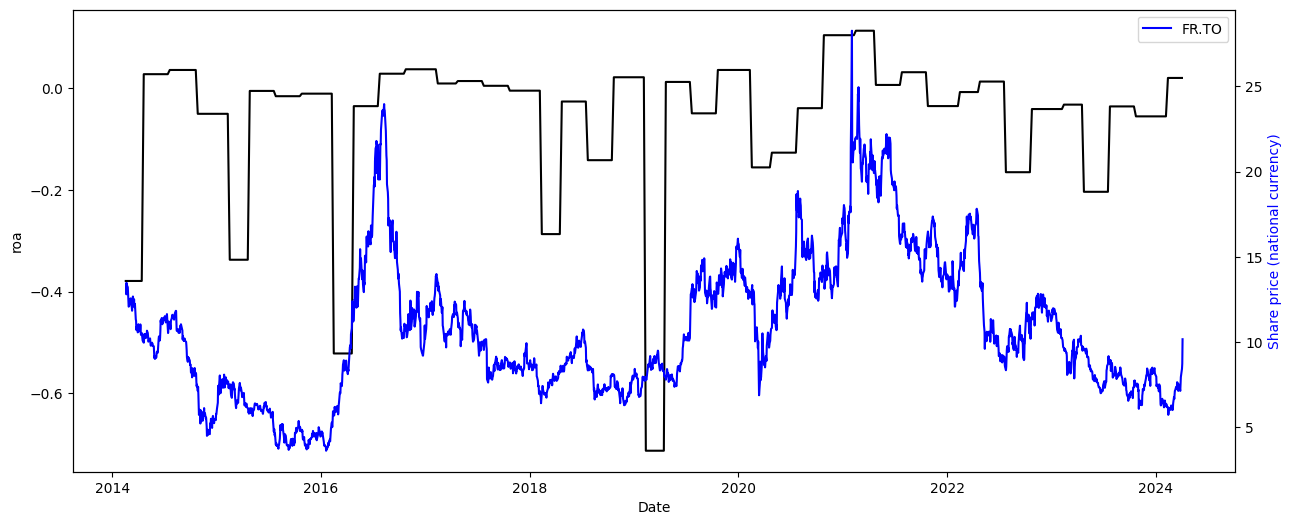

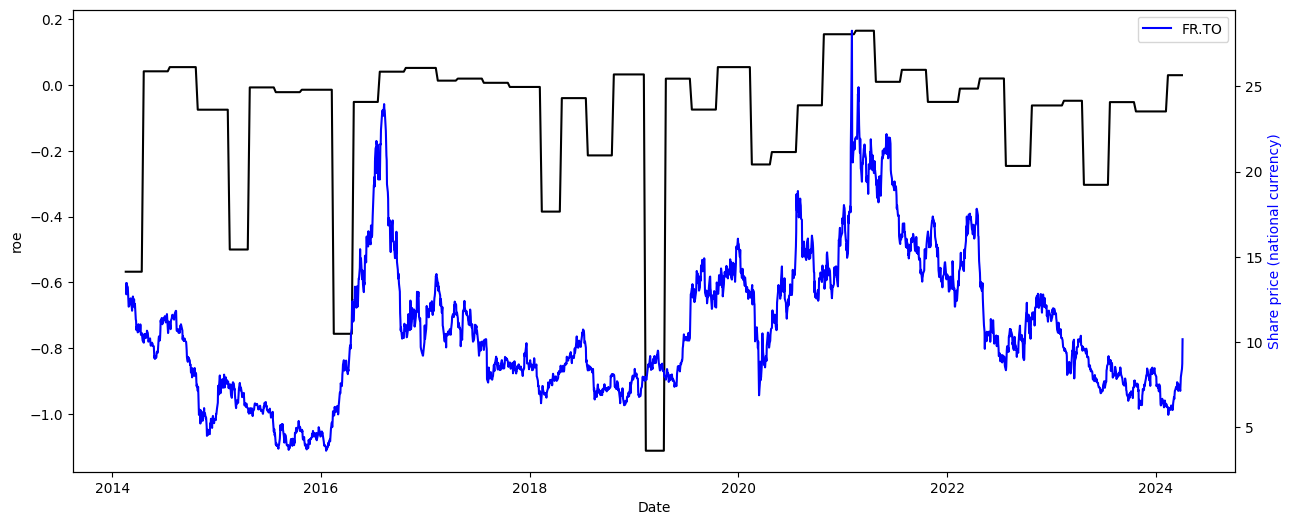

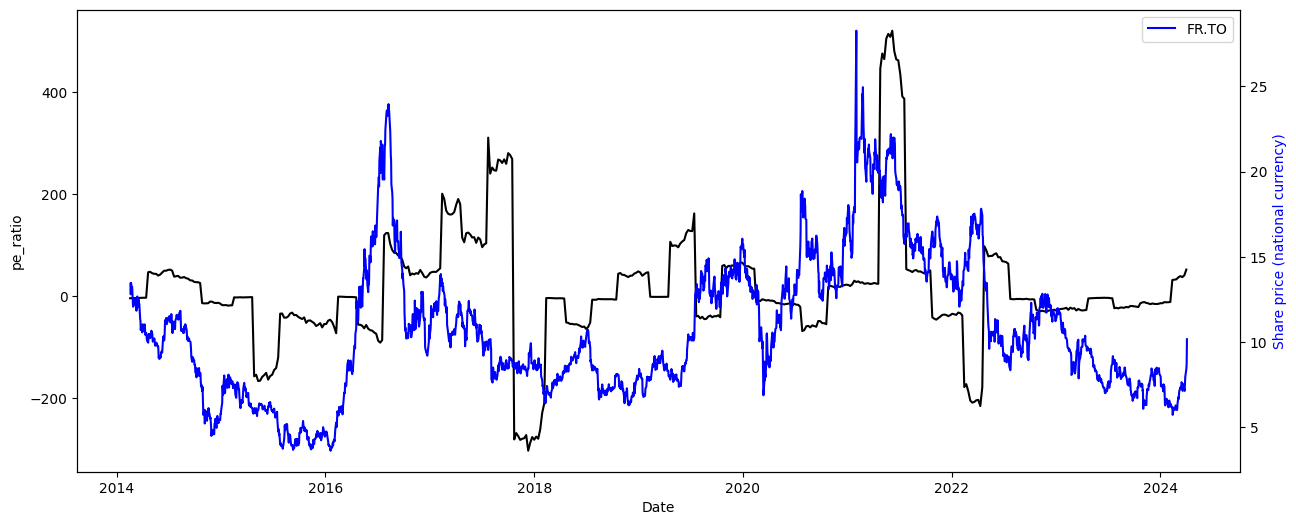

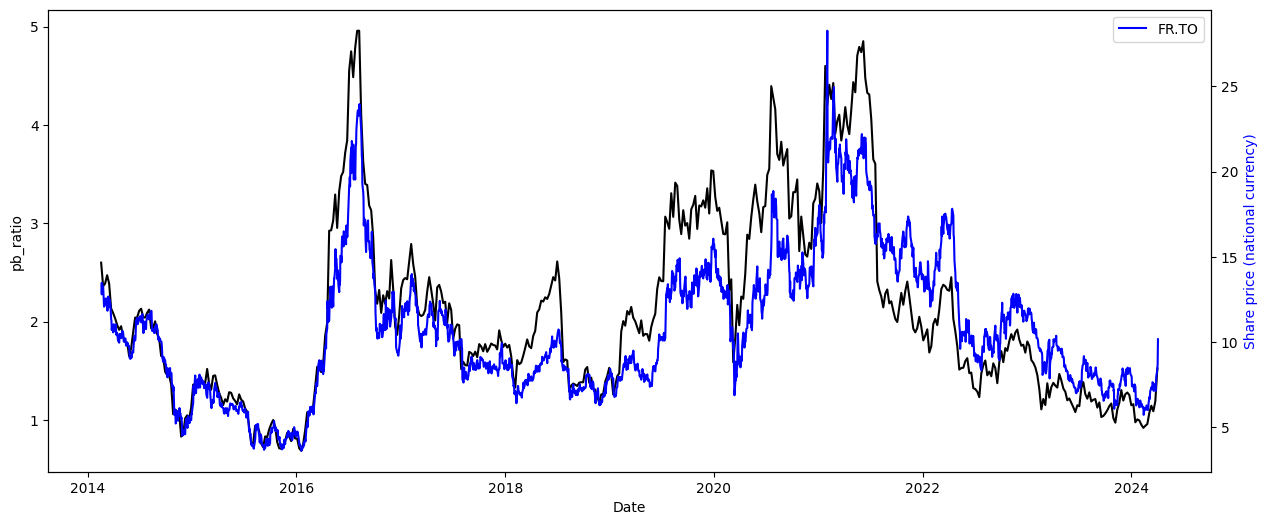

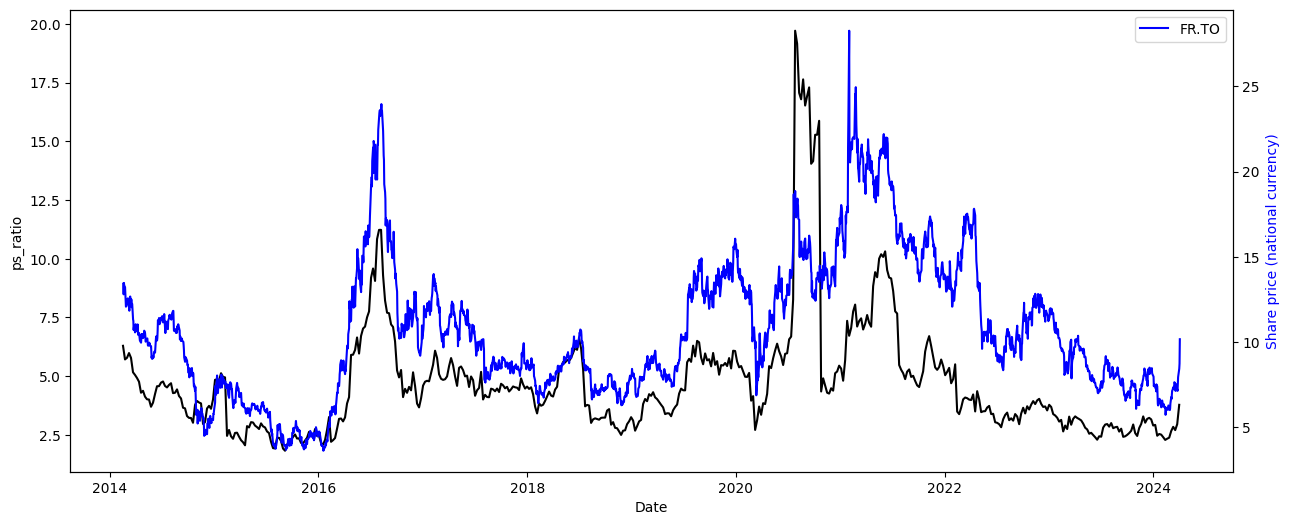

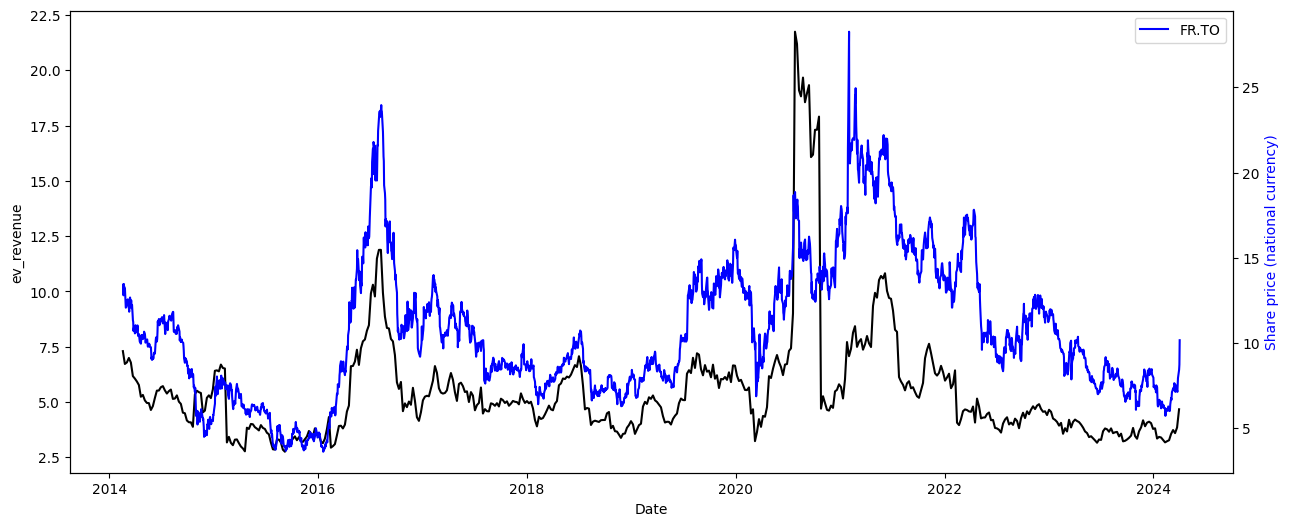

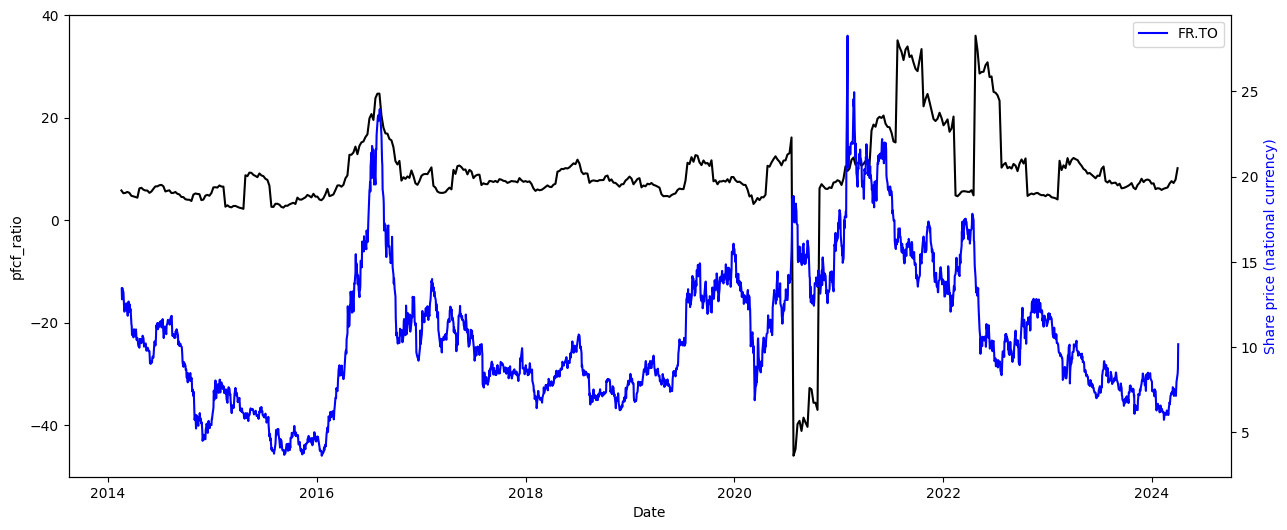

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

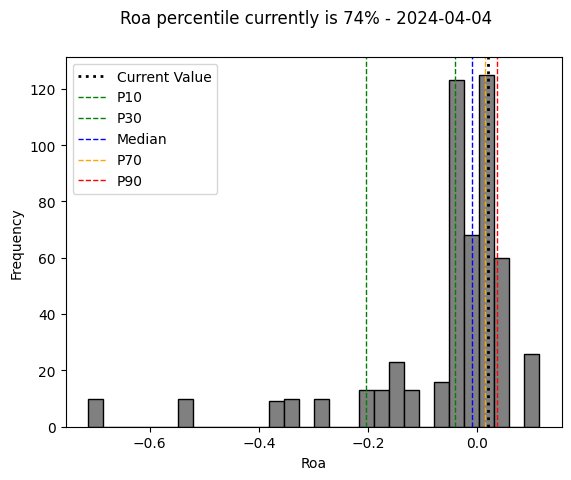

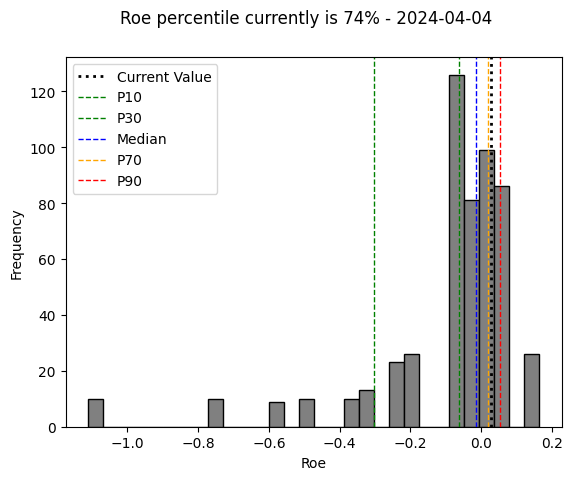

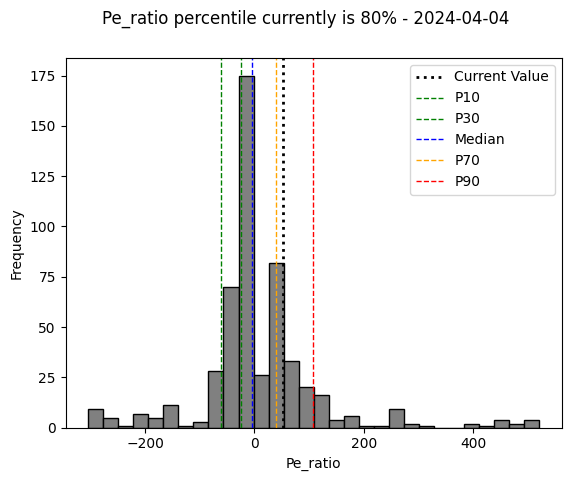

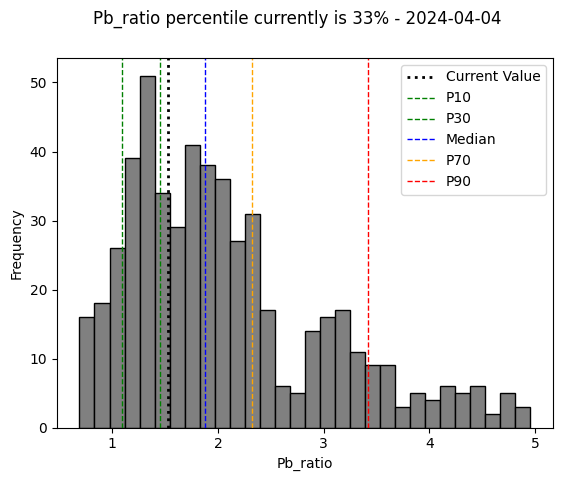

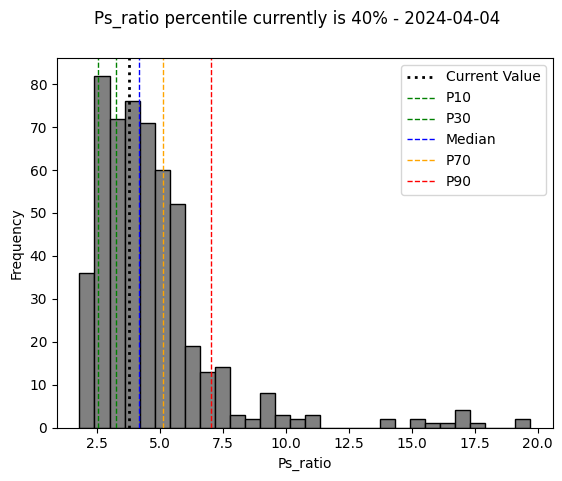

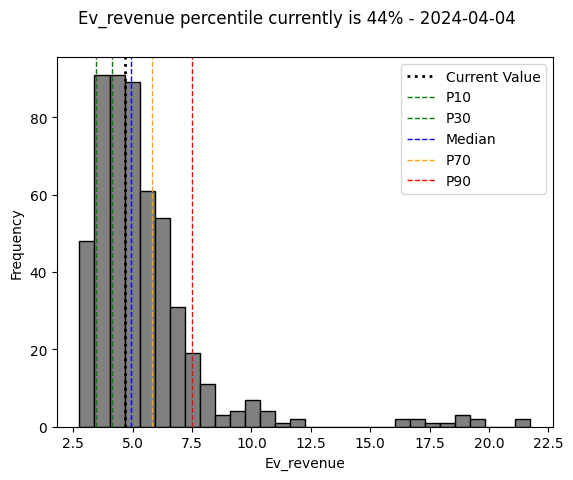

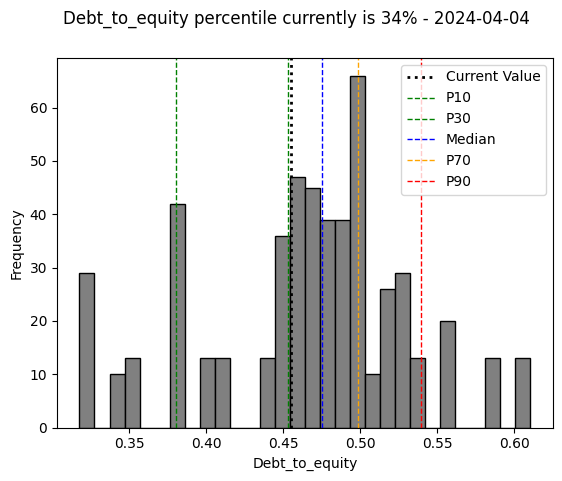

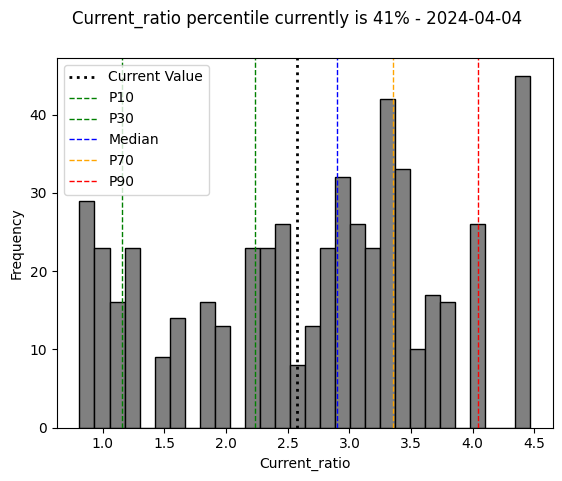

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.999035,0.122687,0.201042,0.155407,0.129821,-0.223409,0.280430
roe,0.999035,1.000000,0.120835,0.192016,0.149331,0.123505,-0.239566,0.273175
pe_ratio,0.122687,0.120835,1.000000,0.319722,0.184373,0.149951,-0.130037,0.285709
pb_ratio,0.201042,0.192016,0.319722,1.000000,0.789553,0.730772,0.198377,0.427866
ps_ratio,0.155407,0.149331,0.184373,0.789553,1.000000,0.993475,0.210254,0.237698
ev_revenue,0.129821,0.123505,0.149951,0.730772,0.993475,1.000000,0.249892,0.158600
debt_to_equity,-0.223409,-0.239566,-0.130037,0.198377,0.210254,0.249892,1.000000,-0.195226
current_ratio,0.280430,0.273175,0.285709,0.427866,0.237698,0.158600,-0.195226,1.000000


8 timestemos have been found!


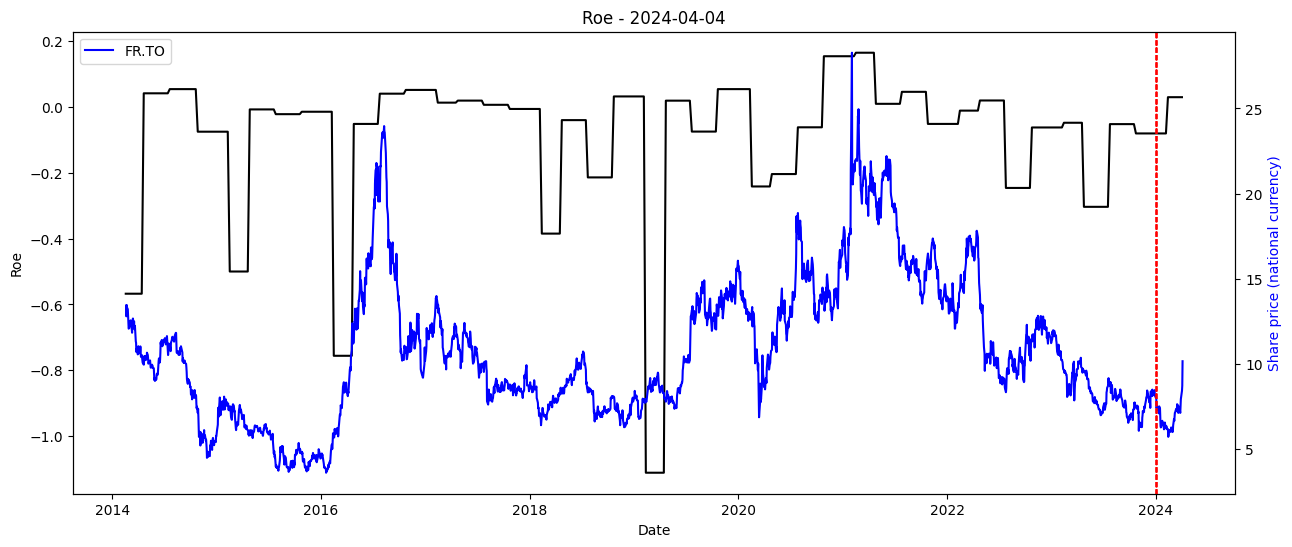

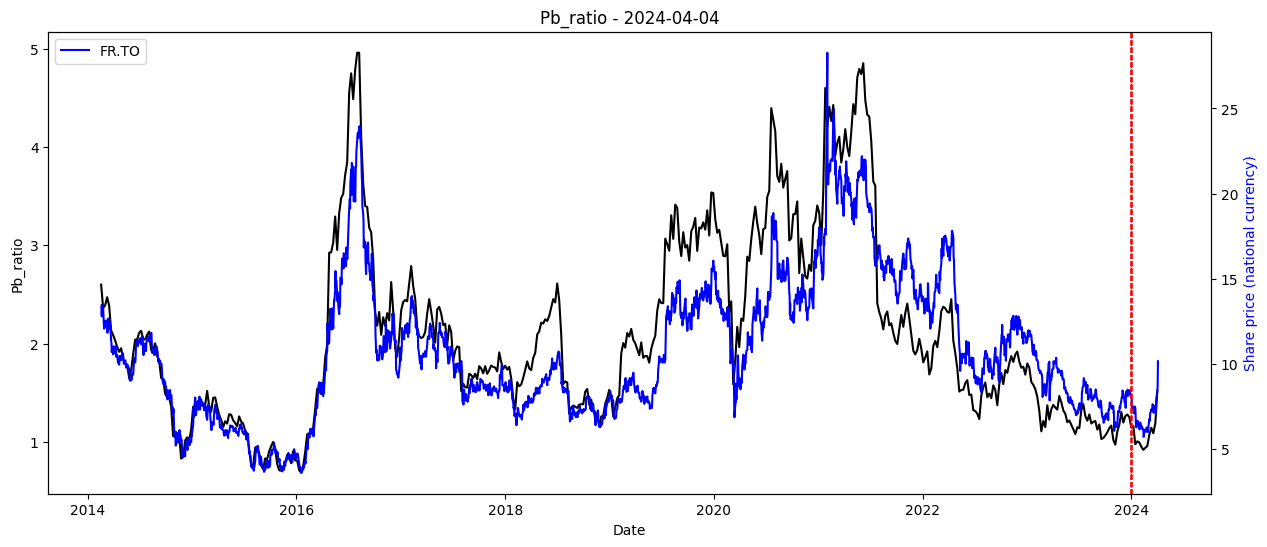

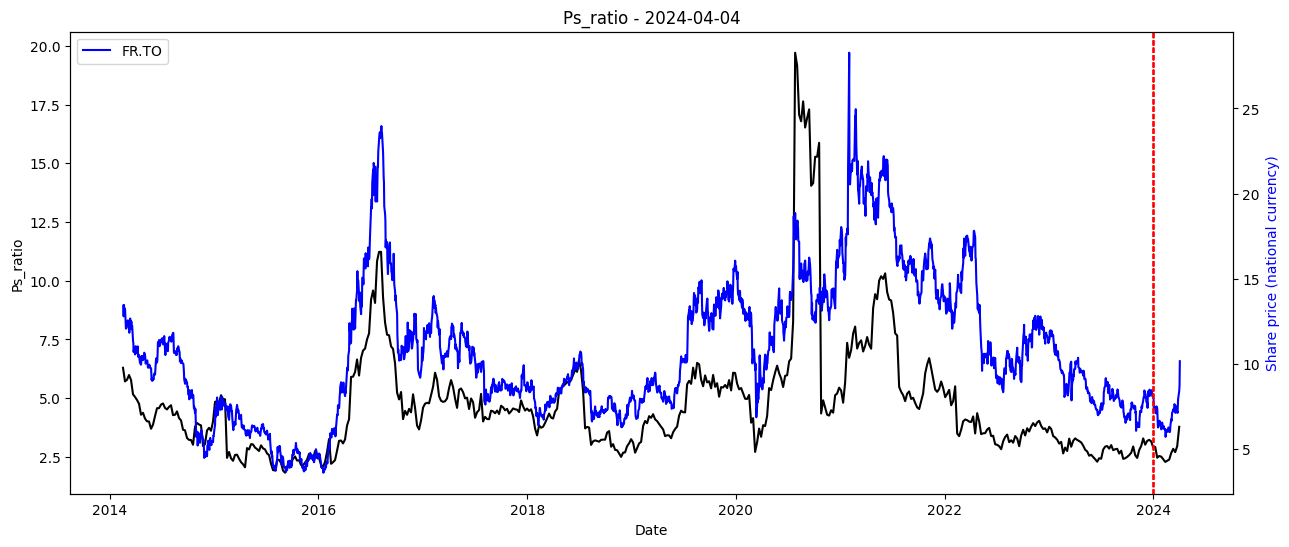

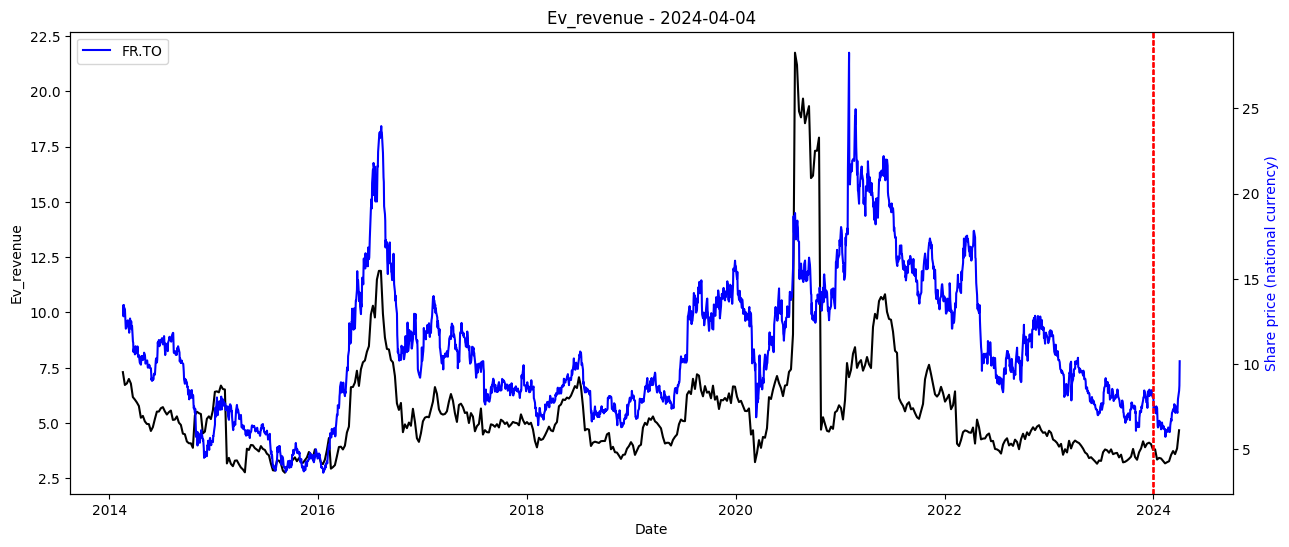

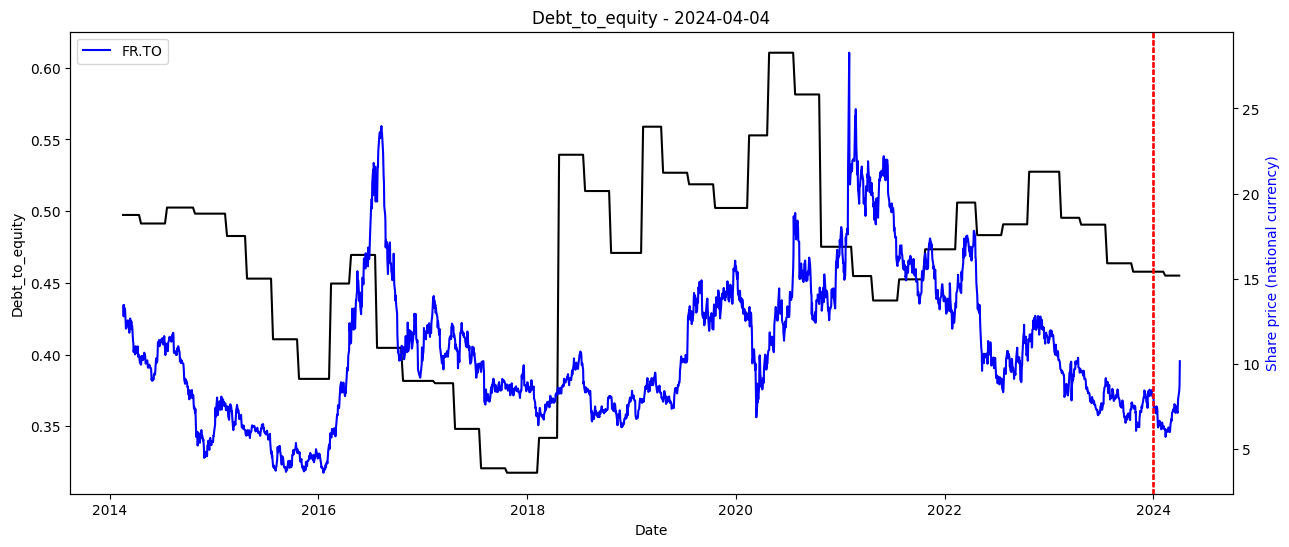

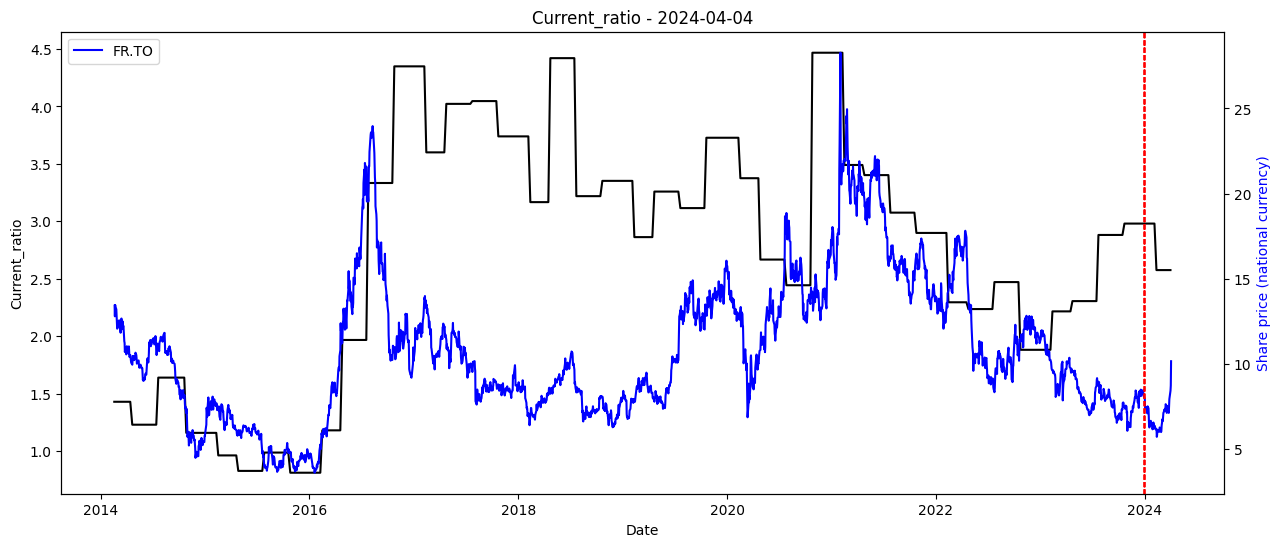

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )